In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

In [2]:
# Random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(52)

# Hyperparameters
batch_size = 64
lr = 0.0002
wlr = 5e-5
beta1 = 0.5
num_epochs = 50
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

dataset = CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))


Files already downloaded and verified


In [3]:
# Initialization function for weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# DCGAN Generator
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# DCGAN Discriminator
class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (3) x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (64) x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (128) x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (256) x 4 x 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),  # Output: (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)  # Flatten the output to a single score



# WGAN Generator
class WGAN_Generator(nn.Module):
    def __init__(self):
        super(WGAN_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define WGAN Discriminator (Critic)
class WGAN_Discriminator(nn.Module):
    def __init__(self):
        super(WGAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)


class WGAN_Discriminator(nn.Module):
    def __init__(self):
        super(WGAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0),  # Final output size = 1
        )
    
    def forward(self, input):
        return self.main(input)


In [4]:
# Initialize models
dcgan_G = DCGAN_Generator().to(device)
dcgan_D = DCGAN_Discriminator().to(device)
wgan_G = WGAN_Generator().to(device)
wgan_D = WGAN_Discriminator().to(device)

dcgan_G.apply(weights_init)
dcgan_D.apply(weights_init)
wgan_G.apply(weights_init)
wgan_D.apply(weights_init)

# DCGAN optimizers and loss
criterion = nn.BCELoss()
dcgan_optimizerD = optim.Adam(dcgan_D.parameters(), lr=lr, betas=(beta1, 0.999))
dcgan_optimizerG = optim.Adam(dcgan_G.parameters(), lr=lr, betas=(beta1, 0.999))

# WGAN optimizers
wgan_optimizerD = optim.RMSprop(wgan_D.parameters(), lr=wlr)
wgan_optimizerG = optim.RMSprop(wgan_G.parameters(), lr=wlr)



In [5]:
from tqdm import tqdm
import numpy as np

# Initialize lists to track epoch-wise data
dcgan_losses_D, dcgan_losses_G = [], []
wgan_losses_D, wgan_losses_G = [], []
dcgan_real_scores, dcgan_fake_scores = [], []
wgan_real_scores, wgan_fake_scores = [], []

print("Starting Training...")
for epoch in range(num_epochs):
    dcgan_epoch_losses_D, dcgan_epoch_losses_G = [], []
    wgan_epoch_losses_D, wgan_epoch_losses_G = [], []
    dcgan_epoch_real_scores, dcgan_epoch_fake_scores = [], []
    wgan_epoch_real_scores, wgan_epoch_fake_scores = [], []

    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, data in pbar:
            real_images = data[0].to(device)
            b_size = real_images.size(0)

            # --- DCGAN Training ---
            # Update Discriminator
            dcgan_D.zero_grad()
            labels = torch.full((b_size,), 1., device=device)
            output_real = dcgan_D(real_images).view(-1)
            loss_real = criterion(output_real, labels)
            loss_real.backward()

            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            fake_images = dcgan_G(noise)
            labels.fill_(0.)
            output_fake = dcgan_D(fake_images.detach()).view(-1)
            loss_fake = criterion(output_fake, labels)
            loss_fake.backward()
            dcgan_optimizerD.step()

            # Update Generator
            dcgan_G.zero_grad()
            labels.fill_(1.)
            output_fake = dcgan_D(fake_images).view(-1)
            loss_G = criterion(output_fake, labels)
            loss_G.backward()
            dcgan_optimizerG.step()

            # Store losses and scores
            dcgan_epoch_losses_D.append(loss_real.item() + loss_fake.item())
            dcgan_epoch_losses_G.append(loss_G.item())
            dcgan_epoch_real_scores.extend(output_real.detach().cpu().numpy())
            dcgan_epoch_fake_scores.extend(output_fake.detach().cpu().numpy())

            # --- WGAN-GP Training ---
            # Update Discriminator (Critic)
            wgan_D.zero_grad()
            real_loss = -torch.mean(wgan_D(real_images))
            fake_images = wgan_G(noise)
            fake_loss = torch.mean(wgan_D(fake_images.detach()))
            loss_critic = real_loss + fake_loss
            loss_critic.backward()
            wgan_optimizerD.step()

            # Clip weights of discriminator 
            for p in wgan_D.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Update Generator every 5 steps
            if i % 5 == 0:
                wgan_G.zero_grad()
                loss_gen = -torch.mean(wgan_D(fake_images))
                loss_gen.backward()
                wgan_optimizerG.step()
                wgan_epoch_losses_G.append(loss_gen.item())

            # Store losses and scores
            wgan_epoch_losses_D.append(loss_critic.item())
            wgan_epoch_real_scores.extend(wgan_D(real_images).detach().cpu().numpy())
            wgan_epoch_fake_scores.extend(wgan_D(fake_images).detach().cpu().numpy())

            # Update progress bar
            pbar.set_postfix(DCGAN_D=np.mean(dcgan_epoch_losses_D), DCGAN_G=np.mean(dcgan_epoch_losses_G),
                             WGAN_D=np.mean(wgan_epoch_losses_D), WGAN_G=np.mean(wgan_epoch_losses_G))

    # Store epoch-wise average losses and scores
    dcgan_losses_D.append(np.mean(dcgan_epoch_losses_D))
    dcgan_losses_G.append(np.mean(dcgan_epoch_losses_G))
    wgan_losses_D.append(np.mean(wgan_epoch_losses_D))
    wgan_losses_G.append(np.mean(wgan_epoch_losses_G))
    dcgan_real_scores.append(np.mean(dcgan_epoch_real_scores))
    dcgan_fake_scores.append(np.mean(dcgan_epoch_fake_scores))
    wgan_real_scores.append(np.mean(wgan_epoch_real_scores))
    wgan_fake_scores.append(np.mean(wgan_epoch_fake_scores))

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] DCGAN_D Loss: {dcgan_losses_D[-1]:.4f}, "
          f"DCGAN_G Loss: {dcgan_losses_G[-1]:.4f}, WGAN_D Loss: {wgan_losses_D[-1]:.4f}, "
          f"WGAN_G Loss: {wgan_losses_G[-1]:.4f}")


Starting Training...


Epoch 1/50: 100%|██████████| 782/782 [00:14<00:00, 55.31it/s, DCGAN_D=0.58, DCGAN_G=4, WGAN_D=-11.1, WGAN_G=-8.01]       


Epoch [1/50] DCGAN_D Loss: 0.5796, DCGAN_G Loss: 3.9983, WGAN_D Loss: -11.0850, WGAN_G Loss: -8.0111


Epoch 2/50: 100%|██████████| 782/782 [00:13<00:00, 57.75it/s, DCGAN_D=0.639, DCGAN_G=3, WGAN_D=-11.9, WGAN_G=-4.68]     


Epoch [2/50] DCGAN_D Loss: 0.6390, DCGAN_G Loss: 3.0011, WGAN_D Loss: -11.9172, WGAN_G Loss: -4.6833


Epoch 3/50: 100%|██████████| 782/782 [00:13<00:00, 57.81it/s, DCGAN_D=0.697, DCGAN_G=2.6, WGAN_D=-4.81, WGAN_G=-4.6]   


Epoch [3/50] DCGAN_D Loss: 0.6967, DCGAN_G Loss: 2.5993, WGAN_D Loss: -4.8085, WGAN_G Loss: -4.6040


Epoch 4/50: 100%|██████████| 782/782 [00:13<00:00, 58.13it/s, DCGAN_D=0.86, DCGAN_G=2.21, WGAN_D=-1.61, WGAN_G=-1.05]  


Epoch [4/50] DCGAN_D Loss: 0.8599, DCGAN_G Loss: 2.2069, WGAN_D Loss: -1.6131, WGAN_G Loss: -1.0499


Epoch 5/50: 100%|██████████| 782/782 [00:13<00:00, 58.14it/s, DCGAN_D=0.866, DCGAN_G=2.03, WGAN_D=-1.34, WGAN_G=-0.34]  


Epoch [5/50] DCGAN_D Loss: 0.8664, DCGAN_G Loss: 2.0313, WGAN_D Loss: -1.3384, WGAN_G Loss: -0.3396


Epoch 6/50: 100%|██████████| 782/782 [00:13<00:00, 57.90it/s, DCGAN_D=0.888, DCGAN_G=2.01, WGAN_D=-0.885, WGAN_G=-0.435]


Epoch [6/50] DCGAN_D Loss: 0.8884, DCGAN_G Loss: 2.0101, WGAN_D Loss: -0.8851, WGAN_G Loss: -0.4350


Epoch 7/50: 100%|██████████| 782/782 [00:13<00:00, 57.76it/s, DCGAN_D=0.838, DCGAN_G=1.99, WGAN_D=-0.488, WGAN_G=-0.328]  


Epoch [7/50] DCGAN_D Loss: 0.8376, DCGAN_G Loss: 1.9912, WGAN_D Loss: -0.4879, WGAN_G Loss: -0.3279


Epoch 8/50: 100%|██████████| 782/782 [00:13<00:00, 57.75it/s, DCGAN_D=0.864, DCGAN_G=1.97, WGAN_D=-0.435, WGAN_G=-0.206] 


Epoch [8/50] DCGAN_D Loss: 0.8639, DCGAN_G Loss: 1.9731, WGAN_D Loss: -0.4352, WGAN_G Loss: -0.2059


Epoch 9/50: 100%|██████████| 782/782 [00:13<00:00, 57.80it/s, DCGAN_D=0.876, DCGAN_G=1.91, WGAN_D=-0.785, WGAN_G=-1.3]  


Epoch [9/50] DCGAN_D Loss: 0.8759, DCGAN_G Loss: 1.9069, WGAN_D Loss: -0.7845, WGAN_G Loss: -1.3042


Epoch 10/50: 100%|██████████| 782/782 [00:13<00:00, 58.01it/s, DCGAN_D=0.897, DCGAN_G=1.91, WGAN_D=-0.83, WGAN_G=-0.156] 


Epoch [10/50] DCGAN_D Loss: 0.8973, DCGAN_G Loss: 1.9059, WGAN_D Loss: -0.8301, WGAN_G Loss: -0.1564


Epoch 11/50: 100%|██████████| 782/782 [00:13<00:00, 58.03it/s, DCGAN_D=0.906, DCGAN_G=1.87, WGAN_D=-1.09, WGAN_G=1.88]   


Epoch [11/50] DCGAN_D Loss: 0.9060, DCGAN_G Loss: 1.8685, WGAN_D Loss: -1.0859, WGAN_G Loss: 1.8844


Epoch 12/50: 100%|██████████| 782/782 [00:13<00:00, 57.91it/s, DCGAN_D=0.902, DCGAN_G=1.88, WGAN_D=-1.45, WGAN_G=1.27]


Epoch [12/50] DCGAN_D Loss: 0.9019, DCGAN_G Loss: 1.8755, WGAN_D Loss: -1.4541, WGAN_G Loss: 1.2670


Epoch 13/50: 100%|██████████| 782/782 [00:13<00:00, 57.87it/s, DCGAN_D=0.886, DCGAN_G=1.89, WGAN_D=-1.22, WGAN_G=-0.169]  


Epoch [13/50] DCGAN_D Loss: 0.8860, DCGAN_G Loss: 1.8890, WGAN_D Loss: -1.2183, WGAN_G Loss: -0.1693


Epoch 14/50: 100%|██████████| 782/782 [00:13<00:00, 57.87it/s, DCGAN_D=0.896, DCGAN_G=1.91, WGAN_D=-1.22, WGAN_G=-0.587]


Epoch [14/50] DCGAN_D Loss: 0.8958, DCGAN_G Loss: 1.9096, WGAN_D Loss: -1.2239, WGAN_G Loss: -0.5868


Epoch 15/50: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s, DCGAN_D=0.871, DCGAN_G=1.91, WGAN_D=-1.15, WGAN_G=-0.407]


Epoch [15/50] DCGAN_D Loss: 0.8713, DCGAN_G Loss: 1.9102, WGAN_D Loss: -1.1537, WGAN_G Loss: -0.4068


Epoch 16/50: 100%|██████████| 782/782 [00:13<00:00, 58.22it/s, DCGAN_D=0.882, DCGAN_G=1.93, WGAN_D=-1.02, WGAN_G=-0.434]  


Epoch [16/50] DCGAN_D Loss: 0.8823, DCGAN_G Loss: 1.9271, WGAN_D Loss: -1.0175, WGAN_G Loss: -0.4338


Epoch 17/50: 100%|██████████| 782/782 [00:13<00:00, 57.94it/s, DCGAN_D=0.875, DCGAN_G=1.93, WGAN_D=-1.02, WGAN_G=-0.644] 


Epoch [17/50] DCGAN_D Loss: 0.8747, DCGAN_G Loss: 1.9275, WGAN_D Loss: -1.0244, WGAN_G Loss: -0.6440


Epoch 18/50: 100%|██████████| 782/782 [00:13<00:00, 57.80it/s, DCGAN_D=0.853, DCGAN_G=1.97, WGAN_D=-0.992, WGAN_G=-0.445]


Epoch [18/50] DCGAN_D Loss: 0.8534, DCGAN_G Loss: 1.9662, WGAN_D Loss: -0.9921, WGAN_G Loss: -0.4448


Epoch 19/50: 100%|██████████| 782/782 [00:13<00:00, 57.76it/s, DCGAN_D=0.851, DCGAN_G=1.98, WGAN_D=-0.957, WGAN_G=-0.277]


Epoch [19/50] DCGAN_D Loss: 0.8506, DCGAN_G Loss: 1.9787, WGAN_D Loss: -0.9574, WGAN_G Loss: -0.2771


Epoch 20/50: 100%|██████████| 782/782 [00:13<00:00, 57.70it/s, DCGAN_D=0.836, DCGAN_G=2.01, WGAN_D=-0.846, WGAN_G=-0.798]


Epoch [20/50] DCGAN_D Loss: 0.8356, DCGAN_G Loss: 2.0116, WGAN_D Loss: -0.8465, WGAN_G Loss: -0.7984


Epoch 21/50: 100%|██████████| 782/782 [00:13<00:00, 57.78it/s, DCGAN_D=0.818, DCGAN_G=2.02, WGAN_D=-0.721, WGAN_G=-1.27]


Epoch [21/50] DCGAN_D Loss: 0.8184, DCGAN_G Loss: 2.0179, WGAN_D Loss: -0.7207, WGAN_G Loss: -1.2725


Epoch 22/50: 100%|██████████| 782/782 [00:13<00:00, 57.79it/s, DCGAN_D=0.844, DCGAN_G=2.05, WGAN_D=-0.752, WGAN_G=-1.49]


Epoch [22/50] DCGAN_D Loss: 0.8438, DCGAN_G Loss: 2.0511, WGAN_D Loss: -0.7516, WGAN_G Loss: -1.4929


Epoch 23/50: 100%|██████████| 782/782 [00:13<00:00, 57.75it/s, DCGAN_D=0.791, DCGAN_G=2.08, WGAN_D=-0.795, WGAN_G=-0.891]


Epoch [23/50] DCGAN_D Loss: 0.7910, DCGAN_G Loss: 2.0817, WGAN_D Loss: -0.7951, WGAN_G Loss: -0.8905


Epoch 24/50: 100%|██████████| 782/782 [00:13<00:00, 57.79it/s, DCGAN_D=0.785, DCGAN_G=2.11, WGAN_D=-0.745, WGAN_G=-0.387]


Epoch [24/50] DCGAN_D Loss: 0.7851, DCGAN_G Loss: 2.1074, WGAN_D Loss: -0.7447, WGAN_G Loss: -0.3872


Epoch 25/50: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s, DCGAN_D=0.782, DCGAN_G=2.14, WGAN_D=-0.697, WGAN_G=-0.867]


Epoch [25/50] DCGAN_D Loss: 0.7816, DCGAN_G Loss: 2.1423, WGAN_D Loss: -0.6969, WGAN_G Loss: -0.8666


Epoch 26/50: 100%|██████████| 782/782 [00:13<00:00, 57.80it/s, DCGAN_D=0.776, DCGAN_G=2.15, WGAN_D=-0.584, WGAN_G=-0.894]


Epoch [26/50] DCGAN_D Loss: 0.7764, DCGAN_G Loss: 2.1500, WGAN_D Loss: -0.5838, WGAN_G Loss: -0.8938


Epoch 27/50: 100%|██████████| 782/782 [00:13<00:00, 57.78it/s, DCGAN_D=0.755, DCGAN_G=2.18, WGAN_D=-0.617, WGAN_G=-0.274]


Epoch [27/50] DCGAN_D Loss: 0.7552, DCGAN_G Loss: 2.1817, WGAN_D Loss: -0.6165, WGAN_G Loss: -0.2738


Epoch 28/50: 100%|██████████| 782/782 [00:13<00:00, 57.73it/s, DCGAN_D=0.752, DCGAN_G=2.22, WGAN_D=-0.507, WGAN_G=-0.231]  


Epoch [28/50] DCGAN_D Loss: 0.7517, DCGAN_G Loss: 2.2241, WGAN_D Loss: -0.5065, WGAN_G Loss: -0.2311


Epoch 29/50: 100%|██████████| 782/782 [00:13<00:00, 57.74it/s, DCGAN_D=0.729, DCGAN_G=2.25, WGAN_D=-0.491, WGAN_G=-0.888]


Epoch [29/50] DCGAN_D Loss: 0.7289, DCGAN_G Loss: 2.2516, WGAN_D Loss: -0.4910, WGAN_G Loss: -0.8882


Epoch 30/50: 100%|██████████| 782/782 [00:13<00:00, 57.84it/s, DCGAN_D=0.734, DCGAN_G=2.26, WGAN_D=-0.469, WGAN_G=-0.94] 


Epoch [30/50] DCGAN_D Loss: 0.7340, DCGAN_G Loss: 2.2565, WGAN_D Loss: -0.4687, WGAN_G Loss: -0.9396


Epoch 31/50: 100%|██████████| 782/782 [00:13<00:00, 57.79it/s, DCGAN_D=0.742, DCGAN_G=2.28, WGAN_D=-0.456, WGAN_G=-1.33] 


Epoch [31/50] DCGAN_D Loss: 0.7418, DCGAN_G Loss: 2.2824, WGAN_D Loss: -0.4556, WGAN_G Loss: -1.3337


Epoch 32/50: 100%|██████████| 782/782 [00:13<00:00, 57.76it/s, DCGAN_D=0.727, DCGAN_G=2.32, WGAN_D=-0.413, WGAN_G=-1.79]


Epoch [32/50] DCGAN_D Loss: 0.7271, DCGAN_G Loss: 2.3237, WGAN_D Loss: -0.4133, WGAN_G Loss: -1.7902


Epoch 33/50: 100%|██████████| 782/782 [00:13<00:00, 57.71it/s, DCGAN_D=0.699, DCGAN_G=2.35, WGAN_D=-0.377, WGAN_G=-2.41]


Epoch [33/50] DCGAN_D Loss: 0.6995, DCGAN_G Loss: 2.3455, WGAN_D Loss: -0.3772, WGAN_G Loss: -2.4142


Epoch 34/50: 100%|██████████| 782/782 [00:13<00:00, 57.74it/s, DCGAN_D=0.693, DCGAN_G=2.37, WGAN_D=-0.344, WGAN_G=-2.43]


Epoch [34/50] DCGAN_D Loss: 0.6932, DCGAN_G Loss: 2.3730, WGAN_D Loss: -0.3439, WGAN_G Loss: -2.4324


Epoch 35/50: 100%|██████████| 782/782 [00:13<00:00, 57.75it/s, DCGAN_D=0.657, DCGAN_G=2.42, WGAN_D=-0.331, WGAN_G=-2.42]


Epoch [35/50] DCGAN_D Loss: 0.6572, DCGAN_G Loss: 2.4208, WGAN_D Loss: -0.3312, WGAN_G Loss: -2.4235


Epoch 36/50: 100%|██████████| 782/782 [00:13<00:00, 57.72it/s, DCGAN_D=0.693, DCGAN_G=2.44, WGAN_D=-0.315, WGAN_G=-2.6] 


Epoch [36/50] DCGAN_D Loss: 0.6932, DCGAN_G Loss: 2.4449, WGAN_D Loss: -0.3148, WGAN_G Loss: -2.5975


Epoch 37/50: 100%|██████████| 782/782 [00:13<00:00, 57.72it/s, DCGAN_D=0.69, DCGAN_G=2.45, WGAN_D=-0.308, WGAN_G=-2.28] 


Epoch [37/50] DCGAN_D Loss: 0.6898, DCGAN_G Loss: 2.4503, WGAN_D Loss: -0.3077, WGAN_G Loss: -2.2773


Epoch 38/50: 100%|██████████| 782/782 [00:13<00:00, 57.74it/s, DCGAN_D=0.639, DCGAN_G=2.48, WGAN_D=-0.296, WGAN_G=-2.28]


Epoch [38/50] DCGAN_D Loss: 0.6393, DCGAN_G Loss: 2.4805, WGAN_D Loss: -0.2961, WGAN_G Loss: -2.2764


Epoch 39/50: 100%|██████████| 782/782 [00:13<00:00, 57.76it/s, DCGAN_D=0.663, DCGAN_G=2.47, WGAN_D=-0.277, WGAN_G=-2.14]


Epoch [39/50] DCGAN_D Loss: 0.6626, DCGAN_G Loss: 2.4740, WGAN_D Loss: -0.2771, WGAN_G Loss: -2.1385


Epoch 40/50: 100%|██████████| 782/782 [00:13<00:00, 57.69it/s, DCGAN_D=0.666, DCGAN_G=2.5, WGAN_D=-0.264, WGAN_G=-2.12] 


Epoch [40/50] DCGAN_D Loss: 0.6662, DCGAN_G Loss: 2.5019, WGAN_D Loss: -0.2642, WGAN_G Loss: -2.1178


Epoch 41/50: 100%|██████████| 782/782 [00:13<00:00, 57.78it/s, DCGAN_D=0.621, DCGAN_G=2.55, WGAN_D=-0.253, WGAN_G=-2.27]


Epoch [41/50] DCGAN_D Loss: 0.6211, DCGAN_G Loss: 2.5468, WGAN_D Loss: -0.2532, WGAN_G Loss: -2.2654


Epoch 42/50: 100%|██████████| 782/782 [00:13<00:00, 57.77it/s, DCGAN_D=0.641, DCGAN_G=2.59, WGAN_D=-0.253, WGAN_G=-2.31]


Epoch [42/50] DCGAN_D Loss: 0.6415, DCGAN_G Loss: 2.5927, WGAN_D Loss: -0.2530, WGAN_G Loss: -2.3144


Epoch 43/50: 100%|██████████| 782/782 [00:13<00:00, 57.72it/s, DCGAN_D=0.617, DCGAN_G=2.6, WGAN_D=-0.252, WGAN_G=-2.44] 


Epoch [43/50] DCGAN_D Loss: 0.6167, DCGAN_G Loss: 2.5991, WGAN_D Loss: -0.2515, WGAN_G Loss: -2.4370


Epoch 44/50: 100%|██████████| 782/782 [00:13<00:00, 57.81it/s, DCGAN_D=0.609, DCGAN_G=2.62, WGAN_D=-0.249, WGAN_G=-2.25]


Epoch [44/50] DCGAN_D Loss: 0.6085, DCGAN_G Loss: 2.6237, WGAN_D Loss: -0.2490, WGAN_G Loss: -2.2496


Epoch 45/50: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s, DCGAN_D=0.621, DCGAN_G=2.66, WGAN_D=-0.25, WGAN_G=-2.22] 


Epoch [45/50] DCGAN_D Loss: 0.6213, DCGAN_G Loss: 2.6579, WGAN_D Loss: -0.2502, WGAN_G Loss: -2.2168


Epoch 46/50: 100%|██████████| 782/782 [00:13<00:00, 57.95it/s, DCGAN_D=0.61, DCGAN_G=2.69, WGAN_D=-0.253, WGAN_G=-2.11] 


Epoch [46/50] DCGAN_D Loss: 0.6099, DCGAN_G Loss: 2.6899, WGAN_D Loss: -0.2533, WGAN_G Loss: -2.1090


Epoch 47/50: 100%|██████████| 782/782 [00:13<00:00, 58.06it/s, DCGAN_D=0.587, DCGAN_G=2.72, WGAN_D=-0.251, WGAN_G=-1.97]


Epoch [47/50] DCGAN_D Loss: 0.5871, DCGAN_G Loss: 2.7217, WGAN_D Loss: -0.2506, WGAN_G Loss: -1.9747


Epoch 48/50: 100%|██████████| 782/782 [00:13<00:00, 58.11it/s, DCGAN_D=0.586, DCGAN_G=2.73, WGAN_D=-0.256, WGAN_G=-2.06]


Epoch [48/50] DCGAN_D Loss: 0.5862, DCGAN_G Loss: 2.7337, WGAN_D Loss: -0.2563, WGAN_G Loss: -2.0630


Epoch 49/50: 100%|██████████| 782/782 [00:13<00:00, 58.22it/s, DCGAN_D=0.583, DCGAN_G=2.75, WGAN_D=-0.25, WGAN_G=-2.12] 


Epoch [49/50] DCGAN_D Loss: 0.5829, DCGAN_G Loss: 2.7502, WGAN_D Loss: -0.2504, WGAN_G Loss: -2.1189


Epoch 50/50: 100%|██████████| 782/782 [00:13<00:00, 58.23it/s, DCGAN_D=0.574, DCGAN_G=2.8, WGAN_D=-0.248, WGAN_G=-2.1]  


Epoch [50/50] DCGAN_D Loss: 0.5737, DCGAN_G Loss: 2.8040, WGAN_D Loss: -0.2482, WGAN_G Loss: -2.1045


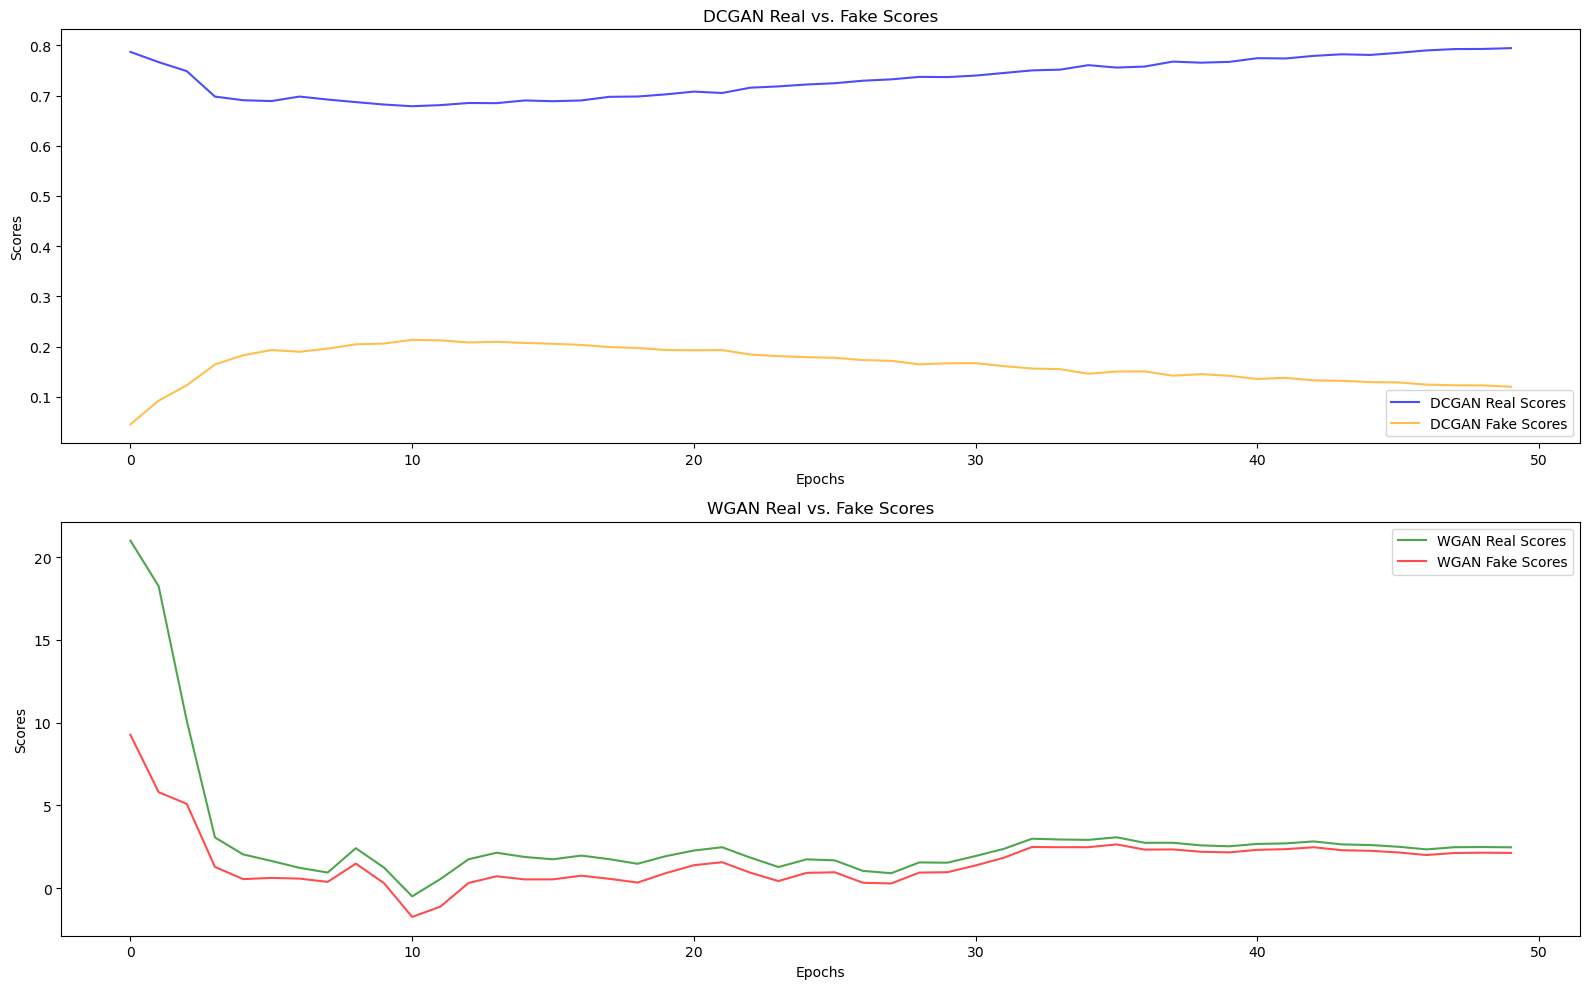

In [6]:
# Ensure scores are 1D for plotting
dcgan_epoch_real_scores = [score.squeeze().item() for score in dcgan_real_scores]
dcgan_epoch_fake_scores = [score.squeeze().item() for score in dcgan_fake_scores]
wgan_epoch_real_scores = [score.squeeze().item() for score in wgan_real_scores]
wgan_epoch_fake_scores = [score.squeeze().item() for score in wgan_fake_scores]

plt.figure(figsize=(16, 10))

# Plot Real vs. Fake Scores for DCGAN
plt.subplot(2, 1, 1)
plt.plot(dcgan_epoch_real_scores, label='DCGAN Real Scores', color='blue', alpha=0.7)
plt.plot(dcgan_epoch_fake_scores, label='DCGAN Fake Scores', color='orange', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('DCGAN Real vs. Fake Scores')
plt.legend()


# Plot Real vs. Fake Scores for WGAN
plt.subplot(2, 1, 2)
plt.plot(wgan_epoch_real_scores, label='WGAN Real Scores', color='green', alpha=0.7)
plt.plot(wgan_epoch_fake_scores, label='WGAN Fake Scores', color='red', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('WGAN Real vs. Fake Scores')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Parameters
images_to_save = 10  # Number of best images to save
latent_dim = 100  # Latent vector size

# Placeholder for the best images
dcgan_best_images = []
wgan_best_images = []

# Generate noise
noise = torch.randn(images_to_save * 10, latent_dim, 1, 1, device=device)

# Generate and score images for DCGAN
with torch.no_grad():
    dcgan_fake_images = dcgan_G(noise)
    dcgan_scores = dcgan_D(dcgan_fake_images).view(-1).cpu().numpy()  # Discriminator's score for each fake image
    top_dcgan_indices = dcgan_scores.argsort()[-images_to_save:][::-1]  # Sorting in descending order
    # Avoid negative strides
    top_dcgan_indices_copy = top_dcgan_indices.copy()  # Ensures no negative strides
    # Convert the copied indices to tensor
    top_dcgan_indices_tensor = torch.tensor(top_dcgan_indices_copy, dtype=torch.long, device=device)
    top_dcgan_images = dcgan_fake_images[top_dcgan_indices_tensor]  # Indexing directly with tensor
    dcgan_best_images.extend(top_dcgan_images)

# Generate and score images for WGAN
with torch.no_grad():
    wgan_fake_images = wgan_G(noise)
    wgan_scores = wgan_D(wgan_fake_images).view(-1).cpu().numpy()  # Discriminator's score for each fake image
    top_wgan_indices = wgan_scores.argsort()[-images_to_save:][::-1]  # Sorting in descending order
    # Avoid negative strides
    top_wgan_indices_copy = top_wgan_indices.copy()  # Ensures no negative strides
    # Convert the copied indices to tensor
    top_wgan_indices_tensor = torch.tensor(top_wgan_indices_copy, dtype=torch.long, device=device)
    top_wgan_images = wgan_fake_images[top_wgan_indices_tensor]  # Indexing directly with tensor
    wgan_best_images.extend(top_wgan_images)

# Combine the best images for each model
dcgan_best_images_tensor = torch.stack(dcgan_best_images)
wgan_best_images_tensor = torch.stack(wgan_best_images)

# Create and save grids for each model
dcgan_grid = vutils.make_grid(dcgan_best_images_tensor, nrow=10, padding=2, normalize=True)
wgan_grid = vutils.make_grid(wgan_best_images_tensor, nrow=10, padding=2, normalize=True)

# Save the image grids
vutils.save_image(dcgan_grid, "dcgan_best_images.png")
vutils.save_image(wgan_grid, "wgan_best_images.png")

print("Best 10 images saved for DCGAN and WGAN.")


Best 10 images saved for DCGAN and WGAN.


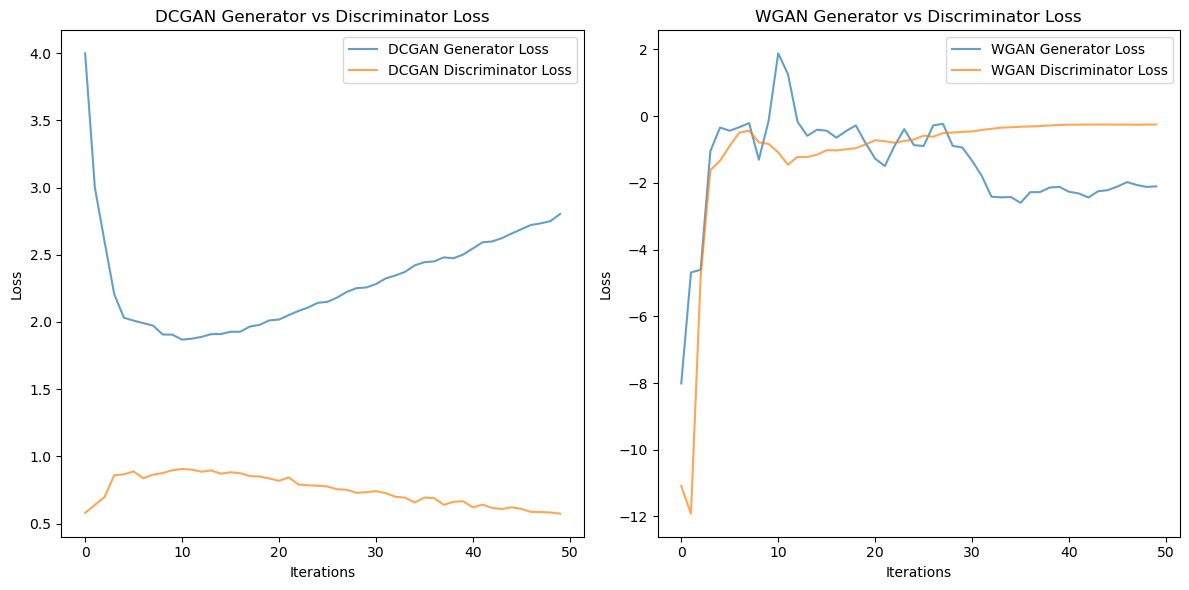

In [8]:
# Plot Generator vs. Discriminator losses for DCGAN and WGAN
plt.figure(figsize=(12, 6))

# DCGAN Losses
plt.subplot(1, 2, 1)
plt.plot(dcgan_losses_G, label='DCGAN Generator Loss', alpha=0.7)
plt.plot(dcgan_losses_D, label='DCGAN Discriminator Loss', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('DCGAN Generator vs Discriminator Loss')
plt.legend()

# WGAN Losses
plt.subplot(1, 2, 2)
plt.plot(wgan_losses_G, label='WGAN Generator Loss', alpha=0.7)
plt.plot(wgan_losses_D, label='WGAN Discriminator Loss', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('WGAN Generator vs Discriminator Loss')
plt.legend()

plt.tight_layout()
plt.show()
